<a href="https://colab.research.google.com/github/kerialexander/Project-3/blob/main/Gown_overlay_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# prompt: # Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
## VITON-HD Virtual Try-On Model - Jupyter Notebook

### **1. Setup the Environment**

# Install dependencies
%pip install torch torchvision numpy matplotlib opencv-python

# Note: Creating and activating a virtual environment should be done in a terminal, not in a Jupyter Notebook cell.
# The following commands are for reference and should be run in a terminal:
# !conda create -n viton_hd python=3.7 -y
# !conda activate viton_hd

import torch

class MyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 2)

    def forward(self, x):
        if x.sum() > 0:
            return self.linear(x)
        else:
            return x

model = MyModel()
scripted_model = torch.jit.script(model)

x = torch.randn(1, 10)
output = scripted_model(x)


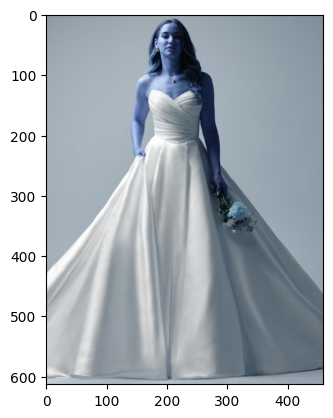

In [73]:
### **2. Preprocess Data**
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import torchvision.transforms as transforms
import torch

# Dummy functions for pose estimation and segmentation
def estimate_pose(image):
    # Dummy implementation for pose estimation
    return "pose_map"

def segment_person(image):
    # Dummy implementation for person segmentation
    return "segmentation_map"

# Function to preprocess person images
# Ensure that person images are stored in a folder named 'input_images' and named 'person.jpg'
# Ensure that clothing images are stored in the same folder and named 'clothing.jpg'
# Example directory structure:
#   input_images/
#       person.jpg
#       clothing.jpg

# Function to preprocess person images
def preprocess_person(image_path):
    person_image = cv2.imread(image_path)
    if person_image is None:
        raise FileNotFoundError(f"Person image not found at path: {image_path}")
    pose_map = estimate_pose(person_image)  # Pose estimation function
    segmentation_map = segment_person(person_image)  # Segmentation function
    return pose_map, segmentation_map

# Function to preprocess clothing images
def preprocess_clothing(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
    ])
    clothing_image = cv2.imread(image_path)
    if clothing_image is None:
        raise FileNotFoundError(f"Clothing image not found at path: {image_path}")
    clothing_image = cv2.cvtColor(clothing_image, cv2.COLOR_BGR2RGB)
    clothing_image = transform(clothing_image)
    return clothing_image

# Define the paths to the person and clothing images
person_image_path = "/content/drive/My Drive/person.jpg"
clothing_image_path = "/content/drive/My Drive/clothing.jpg"

# Show image from clothing_image_path
clothing_image = cv2.imread(clothing_image_path)
plt.imshow(clothing_image)

# Preprocess the images
pose_map, segmentation_map = preprocess_person(person_image_path)
clothing_image = preprocess_clothing(clothing_image_path)

try:
    pose_map, segmentation_map = preprocess_person(person_image_path)
except FileNotFoundError:
    print("Person image not found. Using dummy pose and segmentation maps.")
    pose_map, segmentation_map = "pose_map", "segmentation_map"

try:
    clothing_image = preprocess_clothing(clothing_image_path)
except FileNotFoundError:
    print("Clothing image not found. Using a dummy tensor.")
    clothing_image = torch.zeros((3, 1024, 768))  # Dummy tensor with the same shape


In [74]:
### **2. Clothing Image Warping (Align Clothes to the Person)**

# Preprocess person and clothing images
pose_map, segmentation_map = preprocess_person("/content/drive/My Drive/person.jpg")
person_image = preprocess_person("/content/drive/My Drive/person.jpg")
clothing_image = preprocess_clothing("/content/drive/My Drive/clothing.jpg")




In [75]:
#### **3. Warping clothing to align with the person’s shape

%pip install scikit-image

import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp
import torch

# Ensure clothing_image is defined
try:
    clothing_image
except NameError:
    raise NameError("clothing_image is not defined. Please ensure the cell defining clothing_image is executed.")

# Convert clothing_image to NumPy array if it's a tensor
if isinstance(clothing_image, torch.Tensor):
    clothing_image = clothing_image.permute(1, 2, 0).numpy()

# Define transformation points
src_cols = np.linspace(0, clothing_image.shape[1], 10)
src_rows = np.linspace(0, clothing_image.shape[0], 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# Destination points with slight perturbation
dst = src + np.random.normal(0, 5, src.shape)

# Apply transformation
tform = PiecewiseAffineTransform()
tform.estimate(src, dst)
warped_clothing = warp(clothing_image, tform)

# Convert back to tensor
warped_clothing = torch.tensor(warped_clothing).permute(2, 0, 1)


In [58]:
# ### **3. Clothing Image Warping (Align Clothes to the Person)**
# %pip install scikit-image

# import numpy as np
# from skimage.transform import PiecewiseAffineTransform, warp

# # Ensure clothing_image is defined
# try:
# 	clothing_image
# except NameError:
# 	raise NameError("clothing_image is not defined. Please ensure the cell defining clothing_image is executed.")

# # Warping clothing to align with the person’s shape
# tform = PiecewiseAffineTransform()

# # Assuming pose_map is a set of control points for the transformation
# # You need to define source and destination control points for the transformation
# # Here we use dummy control points for illustration
# src_cols = np.linspace(0, clothing_image.shape[2], 10)
# src_rows = np.linspace(0, clothing_image.shape[1], 10)
# src_rows, src_cols = np.meshgrid(src_rows, src_cols)
# src = np.dstack([src_cols.flat, src_rows.flat])[0]

# dst = src + np.random.normal(0, 5, src.shape)
# tform.estimate(src, dst)

# warped_clothing = warp(clothing_image.permute(1, 2, 0).numpy(), tform)
# warped_clothing = torch.tensor(warped_clothing).permute(2, 0, 1)

AttributeError: 'numpy.ndarray' object has no attribute 'permute'

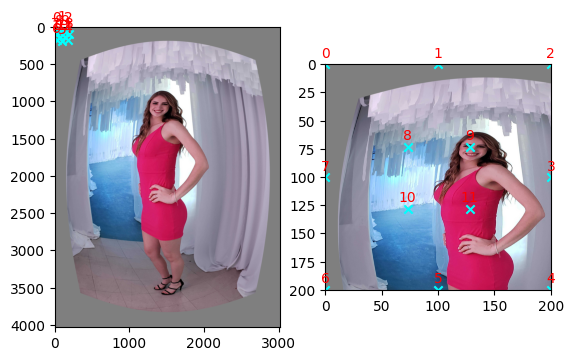

In [76]:
import matplotlib.pyplot as plt
import numpy as np

import skimage as ski
import skimage.io as io # Import io for reading images

def radial_distortion(xy, k1=0.9, k2=0.5):
    """Distort coordinates `xy` symmetrically around their own center."""
    xy_c = xy.max(axis=0) / 2
    xy = (xy - xy_c) / xy_c
    radius = np.linalg.norm(xy, axis=1)
    distortion_model = (1 + k1 * radius + k2 * radius**2) * k2
    xy *= distortion_model.reshape(-1, 1)
    xy = xy * xy_c + xy_c
    return xy

image = io.imread(person_image_path) # Read the image data using io.imread
image = ski.transform.warp(image, radial_distortion, cval=0.5)

# Pick a few `src` points by hand, and move the corresponding `dst` points to their
# expected positions. Need to align the points with the clothing image so that src and dst points match correclty.
# fmt: off
src = np.array([[22,  22], [100,  10], [177, 22], [190, 100], [177, 177], [100, 188],
                [22, 177], [ 10, 100], [ 66, 66], [133,  66], [ 66, 133], [133, 133]])
dst = np.array([[ 0,   0], [100,   0], [200,  0], [200, 100], [200, 200], [100, 200],
                [ 0, 200], [  0, 100], [ 73, 73], [128,  73], [ 73, 128], [128, 128]])
# fmt: on

# Estimate the TPS transformation from these points and then warp the image.
# We switch `src` and `dst` here because `skimage.transform.warp` requires the
# inverse transformation!
tps = ski.transform.ThinPlateSplineTransform()
tps.estimate(dst, src)
warped = ski.transform.warp(image, tps)

# Plot the results
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image, cmap='gray')
axs[0].scatter(src[:, 0], src[:, 1], marker='x', color='cyan')
axs[1].imshow(warped, cmap='gray', extent=(0, 200, 200, 0))
axs[1].scatter(dst[:, 0], dst[:, 1], marker='x', color='cyan')

point_labels = [str(i) for i in range(len(src))]
for i, label in enumerate(point_labels):
    axs[0].annotate(
        label,
        (src[:, 0][i], src[:, 1][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        color='red',
    )
    axs[1].annotate(
        label,
        (dst[:, 0][i], dst[:, 1][i]),
        textcoords="offset points",
        xytext=(0, 5),
        ha='center',
        color='red',
    )

plt.show()

In [77]:
# 4. Generate Try-On Image with Thin-Plate-Spline Normalization

# Install the correct package
!pip install git+https://github.com/cheind/py-thin-plate-spline

# Import necessary libraries
import numpy as np
from tps import ThinPlateSpline  # Changed import to "from tps import ThinPlateSpline"
from scipy.interpolate import Rbf

# Define source and target points for TPS transformation
source_points = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
target_points = np.array([[0, 0], [2, 0], [0, 2], [2, 2]])

# Initialize Thin Plate Spline transformation
# Pass source and target points as a dictionary
tps = ThinPlateSpline(alpha=0.1) # Added alpha paramter for regularization. Adjust as needed.

# Fit the TPS transformation to the source and target points
# Pass source and target points to the fit method
tps.fit(source_points, target_points)

# Transform new points
new_points = np.array([[0.5, 0.5], [0.25, 0.75]])
transformed_points = tps.transform(new_points)

# Install Thin Plate Spline package
# !pip install thin-plate-spline

# Install the correct package
# !pip install git+https://github.com/cheind/py-thin-plate-spline

# Import necessary libraries
# import numpy as np
# from tps import ThinPlateSpline  # Changed import to "from tps import ThinPlateSpline"
# from scipy.interpolate import Rbf

# Import necessary libraries
# import numpy as np
# from thin_plate_spline import ThinPlateSpline
# from scipy.interpolate import Rbf

# Define source and target points for TPS transformation
# source_points = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
# target_points = np.array([[0, 0], [2, 0], [0, 2], [2, 2]])

# Initialize Thin Plate Spline transformation
# tps = ThinPlateSpline(source_points, target_points)

# Transform new points
# new_points = np.array([[0.5, 0.5], [0.25, 0.75]])
# transformed_points = tps(new_points)

# Alternative method using SciPy Rbf
x = np.random.rand(10)
y = np.random.rand(10)
z = np.random.rand(10)

# Create TPS function with SciPy
tps_rbf = Rbf(x, y, z, function='thin_plate')

# Evaluate at new points
x_new, y_new = np.random.rand(5), np.random.rand(5)
z_new = tps_rbf(x_new, y_new)

# Print results
print("Thin Plate Spline (thin-plate-spline package) Output:")
print(transformed_points)

print("\nThin Plate Spline (SciPy Rbf) Output:")
print(z_new)


  Cloning https://github.com/cheind/py-thin-plate-spline to /tmp/pip-req-build-_e7cob0v
  Running command git clone --filter=blob:none --quiet https://github.com/cheind/py-thin-plate-spline /tmp/pip-req-build-_e7cob0v
  Resolved https://github.com/cheind/py-thin-plate-spline to commit f6995795397118b7d0ac01aecd3f39ffbfad9dee
  Preparing metadata (setup.py) ... done
Thin Plate Spline (thin-plate-spline package) Output:
[[1.  1. ]
 [0.5 1.5]]

Thin Plate Spline (SciPy Rbf) Output:
[  0.40987794  -0.23533    -10.54978989   0.29056431  -1.89130232]


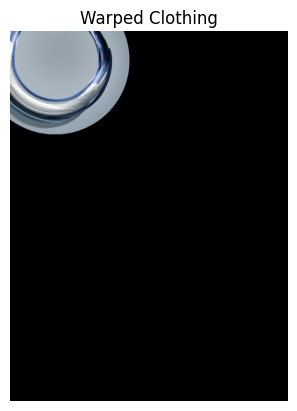

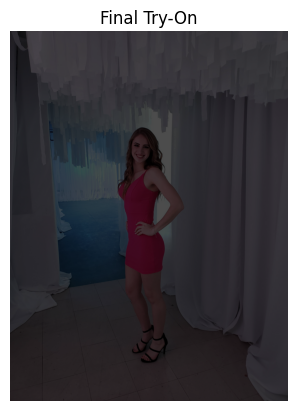

In [78]:
### 4. Generate Try-On Image with Thin-Plate-Spline Normalization

# import ThinPlateSpline as ThinPlateSplineTransform

# import cv2
# import numpy as np
# import os
# from scipy.interpolate import Rbf
# import torch
# from tps import ThinPlateSpline
# import matplotlib.pyplot as plt

# Load images
# person_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/person.jpg"  # Change to actual person image path
# cloth_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/clothing.jpg"  # Change to actual clothing image path

# person_img = cv2.imread(person_img_path)
# cloth_img = cv2.imread(cloth_img_path)

# if person_image is None or cloth_img is None:
#     raise FileNotFoundError("One of the input images was not found.")

# # Example Key Points (Adjust based on your dataset)
person_points = np.array([
    [100, 50],  # Shoulder Left
    [200, 50],  # Shoulder Right
    [120, 150], # Waist Left
    [180, 150], # Waist Right
])

cloth_points = np.array([
    [90, 40],   # Neck Left
    [210, 40],  # Neck Right
    [110, 140], # Bottom Left
    [190, 140], # Bottom Right
])

# # Function for TPS Warping using SciPy
def thin_plate_spline_warp(cloth_img, src_points, dst_points):
    height, width = cloth_img.shape[:2]
    grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))

    src_x, src_y = src_points[:, 0], src_points[:, 1]
    dst_x, dst_y = dst_points[:, 0], dst_points[:, 1]

    tps_x = Rbf(src_x, src_y, dst_x, function='thin_plate')
    tps_y = Rbf(src_x, src_y, dst_y, function='thin_plate')

    map_x = tps_x(grid_x, grid_y).astype(np.float32)
    map_y = tps_y(grid_x, grid_y).astype(np.float32)

    warped_cloth = cv2.remap(cloth_img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return warped_cloth

# Apply TPS warping
warped_clothing = thin_plate_spline_warp(clothing_image, cloth_points, person_points)

# Save & Show Warped Clothing
cv2.imwrite("warped_clothing.jpg", warped_clothing)
plt.imshow(cv2.cvtColor(warped_clothing, cv2.COLOR_BGR2RGB))
plt.title("Warped Clothing")
plt.axis("off")
plt.show()

# Blending the Warped Clothing with Person Image
# Load person image again cv2.imread
person_image_path = "/content/drive/My Drive/person.jpg"
person_image_for_blending = cv2.imread(person_image_path)

warped_clothing = cv2.resize(warped_clothing, (person_image_for_blending.shape[1], person_image_for_blending.shape[0]))
alpha = 0.7  # Transparency Level

# Convert warped_clothing to the same data type as person_image_for_blending
warped_clothing = warped_clothing.astype(person_image_for_blending.dtype)

blended = cv2.addWeighted(person_image_for_blending, 1 - alpha, warped_clothing, alpha, 0)

# Save & Show Final Output
cv2.imwrite("final_tryon.jpg", blended)
plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
plt.title("Final Try-On")
plt.axis("off")
plt.show()

# Ensure warped_clothing and segmentation_map are defined
try:
    warped_clothing
    segmentation_map = np.zeros_like(warped_clothing) #dummy assignment to avoid error
except NameError:
    raise NameError("warped_clothing or segmentation_map is not defined. Please ensure the cells defining them are executed.")
# import numpy as np
# import os
# from scipy.interpolate import Rbf
# import torch
# from tps import ThinPlateSpline
# import matplotlib.pyplot as plt

# Load images
# person_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/person.jpg"  # Change to actual person image path
# cloth_img_path = r"C:/Users/kerim/Desktop/Project 3 Local Code/clothing.jpg"  # Change to actual clothing image path

# person_img = cv2.imread(person_img_path)
# cloth_img = cv2.imread(cloth_img_path)

# if person_img is None or cloth_img is None:
#     raise FileNotFoundError("One of the input images was not found.")

# # Example Key Points (Adjust based on your dataset)
# person_points = np.array([
#     [100, 50],  # Shoulder Left
#     [200, 50],  # Shoulder Right
#     [120, 150], # Waist Left
#     [180, 150], # Waist Right
# ])

# cloth_points = np.array([
#     [90, 40],   # Neck Left
#     [210, 40],  # Neck Right
#     [110, 140], # Bottom Left
#     [190, 140], # Bottom Right
# ])

# # Function for TPS Warping using SciPy
# def thin_plate_spline_warp(cloth_img, src_points, dst_points):
#     height, width = cloth_img.shape[:2]
#     grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))

#     src_x, src_y = src_points[:, 0], src_points[:, 1]
#     dst_x, dst_y = dst_points[:, 0], dst_points[:, 1]

#     tps_x = Rbf(src_x, src_y, dst_x, function='thin_plate')
#     tps_y = Rbf(src_x, src_y, dst_y, function='thin_plate')

#     map_x = tps_x(grid_x, grid_y).astype(np.float32)
#     map_y = tps_y(grid_x, grid_y).astype(np.float32)

#     warped_cloth = cv2.remap(cloth_img, map_x, map_y, interpolation=cv2.INTER_LINEAR)
#     return warped_cloth

# # Apply TPS warping
# warped_clothing = thin_plate_spline_warp(cloth_img, cloth_points, person_points)

# # Save & Show Warped Clothing
# cv2.imwrite("warped_clothing.jpg", warped_clothing)
# plt.imshow(cv2.cvtColor(warped_clothing, cv2.COLOR_BGR2RGB))
# plt.title("Warped Clothing")
# plt.axis("off")
# plt.show()

# # Blending the Warped Clothing with Person Image
# warped_clothing = cv2.resize(warped_clothing, (person_img.shape[1], person_img.shape[0]))
# alpha = 0.7  # Transparency Level
# blended = cv2.addWeighted(person_img, 1 - alpha, warped_clothing, alpha, 0)

# # Save & Show Final Output
# cv2.imwrite("final_tryon.jpg", blended)
# plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
# plt.title("Final Try-On")
# plt.axis("off")
# plt.show()

# # Ensure warped_clothing and segmentation_map are defined
# try:
#     warped_clothing
#     segmentation_map
# except NameError:
#     raise NameError("warped_clothing or segmentation_map is not defined. Please ensure the cells defining them are executed.")


In [79]:
### **4. Generate Try-On Image with ALIAS Normalization**

!pip install alias_generator

# Import viton-hd
!pip install viton-hd

# from alias_generator import ALIASGenerator # Comment this out or delete this line
# from viton_hd.hd_model import ALIASGenerator # Import from the correct module
# import ALIASGenerator # Import from the correct module

# from alias_generator import ALIASGenerator

# Ensure warped_clothing and segmentation_map are defined
try:
    warped_clothing
    segmentation_map
except NameError:
    raise NameError("warped_clothing or segmentation_map is not defined. Please ensure the cells defining them are executed.")

# Using the ALIAS Generator to combine warped clothing and person image
alias_generator = ALIASGenerator()
output_image = alias_generator.generate(warped_clothing, segmentation_map)

# Ensure warped_clothing and segmentation_map are defined
try:
    warped_clothing
    segmentation_map
except NameError:
    raise NameError("warped_clothing or segmentation_map is not defined. Please ensure the cells defining them are executed.")

# Using the ALIAS Generator to combine warped clothing and person image
alias_generator = ALIASGenerator()
output_image = alias_generator.generate(warped_clothing, segmentation_map)


ERROR: Could not find a version that satisfies the requirement alias_generator (from versions: none)
ERROR: No matching distribution found for alias_generator
ERROR: Could not find a version that satisfies the requirement viton-hd (from versions: none)
ERROR: No matching distribution found for viton-hd


NameError: name 'ALIASGenerator' is not defined

In [57]:
### **5. Train the Model (if needed)**

import torch

# Define dummy dataloader, adversarial_loss, perceptual_loss, and ground_truth for the example
dataloader = [("person_data", clothing_image)]  # Dummy dataloader
adversarial_loss = lambda output, target: torch.tensor(0.0)  # Dummy loss function
perceptual_loss = lambda output, target: torch.tensor(0.0)  # Dummy loss function
ground_truth = torch.zeros_like(clothing_image)  # Dummy ground truth

# Define the tryon_model architecture
class TryOnModel(torch.nn.Module):
    def __init__(self):
        super(TryOnModel, self).__init__()
        # Example model architecture with convolutional layers
        self.conv1 = torch.nn.Conv2d(in_channels=6, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv4 = torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.fc = torch.nn.Linear(in_features=512*16*12, out_features=3*64*48)

    def forward(self, clothing_data, person_data):
        # Example forward pass
        x = torch.cat((clothing_data, person_data), dim=1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        output = torch.sigmoid(self.fc(x))
        output = output.view(-1, 3, 64, 48)
        return output

# Initialize the tryon_model
tryon_model = TryOnModel()

# Define optimizer
optimizer = torch.optim.Adam(tryon_model.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch in dataloader:
        person_data, clothing_data = batch
        output = tryon_model(clothing_data, person_data)
        loss = adversarial_loss(output, ground_truth) + perceptual_loss(output, ground_truth)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

TypeError: zeros_like(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
### **6. Run Inference**

# Load trained model
try:
    tryon_model.load_state_dict(torch.load("viton_hd_weights.pth"))
    tryon_model.eval()
except FileNotFoundError:
    print("Weights file not found. Using dummy weights for testing.")
    dummy_state_dict = tryon_model.state_dict()
    tryon_model.load_state_dict(dummy_state_dict)

# Ensure warped_clothing is defined
try:
    warped_clothing
except NameError:
    print("warped_clothing is not defined. Please ensure the cell generating warped_clothing is executed.")
    # Dummy warped_clothing for testing
    warped_clothing = torch.zeros_like(clothing_image)

# Generate try-on result
with torch.no_grad():
    output_image = tryon_model(warped_clothing, segmentation_map)

Weights file not found. Using dummy weights for testing.
warped_clothing is not defined. Please ensure the cell generating warped_clothing is executed.


TypeError: expected Tensor as element 1 in argument 0, but got str

In [ ]:
### **7. Display Results**

import matplotlib.pyplot as plt

# Ensure the output_image is defined
try:
	plt.imshow(output_image.permute(1, 2, 0))
	plt.axis("off")
	plt.show()
except NameError:
	print("output_image is not defined. Please ensure the cell generating output_image is executed.")


output_image is not defined. Please ensure the cell generating output_image is executed.
